## Reward Signals
Data Collected at Rutgers University by David Smith

In [2]:
!git clone https://github.com/CalebRHaynes/reward-signals.git

Cloning into 'reward-signals'...
remote: Enumerating objects: 831, done.
remote: Counting objects: 100% (831/831), done.
remote: Compressing objects: 100% (800/800), done.
remote: Total 1373 (delta 32), reused 828 (delta 30), pack-reused 542
Receiving objects: 100% (1373/1373), 16.79 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [11]:
%cd reward-signals/
!ls

/content/reward-signals
analyze_behavior.m     make_3col_files_m03.m	      scanner_practice.m
analyze_learning.m     make_3col_files_m04.m	      ScanningProcedures.docx
analyze_ratings.m      make_3col_files_m05.m	      simulate_points3.m
CardTask.m	       make_3col_files_m06.m	      SocialExp_MyBad.xlsx
data		       make_3col_files_SingleTrial.m  SocRewardTask_outside.m
data_csv	       make_TbTresponses.m	      SocRewardTask_scanner.m
evfiles_m02	       outcomes.mat		      starstim.m
fsl		       poster_figures		      TaskInstructions.docx
get_behavior.m	       ptb			      utility.py
get_summary.m	       QA_09-Nov-2016runs.xlsx	      Vwalk_all_v1.mat
imgs		       QA_summary.m		      Vwalk_all_v2.mat
InstructionsQuiz.docx  randomwalk3.m		      Vwalk_all_v3.mat
L1_SingleTrial.sh      randomwalk4.m		      Vwalk_all_v4.mat
make_3col_files.m      rutgers_socreward.ipynb	      Vwalk_all_v5.mat
make_3col_files_m02.m  rw


### Variable Key

#### Raw Data Names
- soc_win - affective feedback in a trial. 0 lose and 1 is win 
- partner - 0 is nonsocial and 1  is social
- deckchoice - 1 or 2 based on participant choice of option. 1 = star, 2 = pentagon
- lapse1 and lapse2 - participant did not respond in respective decision phase

#### Derived Data Names
##### Columns renamed
- index - renamed from raw data index
- choice - renamed from raw data column 'deckchoice'
- is_social - renamed from raw data column 'partner'
- aff_feedback_curr - renamed from raw data 'soc_win'

##### Columns derived
- aff_feedback_prev - aff_feedback_curr shifted by one trial to reflect trial -1
- prev_is_social - is_social shifted by one trial to reflect trial -1
- prev_aff_fb - affective feedback in the previous trial, 0 is lose and 1 is win
- star_points - known value of option 1 
- pentagon_points - known value of option 2 
- diff_point - star_points - pentagon_points

In [12]:
import pandas as pd
from utility import *

#sub class for easy dataframe access
class Subject():

    def __init__(self, subnum):
        self.subnum = subnum
        self.matfiles = [i for i in file_list if str(subnum) in i]
        self.df = make_derived_df(self.matfiles)

#### Logistic Models

In [13]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import scipy.stats as stats

#list of regressors
reg_list = ['choice', 'is_social', 'aff_feedback_prev',
                             'prev_diff_points']

#gets beta weights predicting choice 
def get_weights_model1(df, columns = reg_list):

        df = df[columns]
        # split dataframe into data and the label to be predicted
        data = (df.iloc[:, 1:]).apply(stats.zscore)
        
        #data labels, recode 1 and 2 as 0 and 1
        labels = (df.iloc[:, :1] - 1)
        
        # make interaction variables
        # Affective Feedback from prior trial * point difference
        data['prev_aff * difference'] = data['aff_feedback_prev'] * data['prev_diff_points']
        
        col_list = data.columns.to_list()
        
        X = np.array(data.values.tolist())
        y = np.array(labels.values.tolist()).ravel()

        # fit model
        clf = LogisticRegression()
        clf.fit(X, y)
        #coef_dict = {col_list[i]: clf.coef_[0][i] for i in range(len(col_list))}
        
        return clf.coef_[0].tolist()

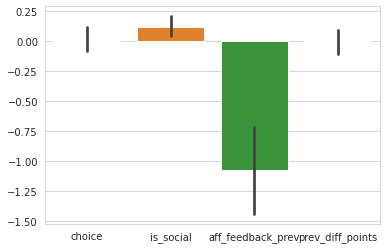

In [14]:
#get subject list from list of files 
subject_list = (pd.Series([(i.split('/'))[1] for i in file_list]).unique())

#make dataframe where subjects are rows and B0 per regressor are columns 
df = pd.DataFrame()
for i in subject_list:
    x = list({i: get_weights_model1(Subject(i).df)}.values())[0]
    df[i] = x

df = df.transpose()
df.columns = reg_list
#plot
sns.set_style("whitegrid")
ax = sns.barplot(data=df)